In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

from elo import Elo as ELO
from glicko2 import Glicko2 as GLICKO
import trueskill as ts

In [2]:
# source https://www.kaggle.com/thefc17/bundesliga-results-19932018/version/1
bl = pd.read_csv('Bundesliga_Results.csv', parse_dates=['Date'])

This dataset contains results from every Bundesliga match from 1993-1994 to 2017-2018. It also includes half time results, but only from 1995-96 to 2017-18. Columns include Division (denoted as D1), HomeTeam, AwayTeam, FTHG (final time home goals), FTAG (final time away goals), FTR (full time result), HTHG (half time home goals), HTAG (half time away goals), HTR (half time result), and season.

Data compiled into one file from this site: http://www.football-data.co.uk/germanym.php

In [3]:
bl.sort_values(by='Date', inplace=True)
bl.reset_index(inplace=True)
bl.HomeTeam = bl.HomeTeam.apply(lambda x: x.lower().replace(' ', ''))
bl.AwayTeam = bl.AwayTeam.apply(lambda x: x.lower().replace(' ', ''))
# add draws to the winner, doesn't really matter
bl['home_win'] = np.where(bl.FTHG >= bl.FTAG, 1, 0)
bl['draw'] = np.where(bl.FTHG==bl.FTAG, 1, 0)
bl['away_win'] = np.where(bl.FTHG < bl.FTAG, 1, 0)
bl['winner'] = (bl.HomeTeam * (bl.home_win) + bl.AwayTeam * bl.away_win)
bl['loser'] = (bl.HomeTeam * (1 - bl.home_win) + bl.AwayTeam * (1 - bl.away_win))

print('Dataset contains {} matches from {} to {}. Home won {} ({}%). There were {} draws ({}%).'.format(len(bl), bl.Date.min().date(), bl.Date.max().date(), bl.home_win.sum(), int(100*bl.home_win.sum()/len(bl)), bl.draw.sum(), int(100*bl.draw.sum()/len(bl)) ))

Dataset contains 7650 matches from 1993-01-09 to 2018-12-05. Home won 5551 (72%). There were 1964 draws (25%).


In [4]:
def get_matchup(row):
    if row.FTHG >= row.FTAG:
        winner_is_home = True
    else:
        winner_is_home = False
    if row.FTHG == row.FTAG:
        draw = True
    else:
        draw = False
    return (winner_is_home, draw)

In [5]:
# the methods all use the same signature so we can use a generic function to call them
def update_ratings(calc, source, winner, loser, draw):
    winner_rating = source[winner][-1]
    loser_rating = source[loser][-1]
    winner_rating_new, loser_rating_new = calc.rate_1vs1(winner_rating, loser_rating, drawn=draw)
    source[winner].append(winner_rating_new)
    source[loser].append(loser_rating_new)
    return winner_rating_new, loser_rating_new

In [6]:
bl.head()

,index,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season,home_win,draw,away_win,winner,loser
0,44,D1,1993-01-09,werderbremen,duisburg,1,5,A,NaN,NaN,NaN,1993-94,0,0,1,duisburg,werderbremen
1,42,D1,1993-01-09,m'gladbach,schalke04,3,2,H,NaN,NaN,NaN,1993-94,1,0,0,m'gladbach,schalke04
2,41,D1,1993-01-09,kaiserslautern,nurnberg,3,1,H,NaN,NaN,NaN,1993-94,1,0,0,kaiserslautern,nurnberg
3,40,D1,1993-01-09,hamburg,leverkusen,2,1,H,NaN,NaN,NaN,1993-94,1,0,0,hamburg,leverkusen
4,39,D1,1993-01-09,fckoln,freiburg,2,0,H,NaN,NaN,NaN,1993-94,1,0,0,fckoln,freiburg


In [7]:
teams = list(set(list(bl.winner.values) + list(bl.loser.values)))

In [8]:
# dictionary from team to DF row
participation = defaultdict(list)

# dictionary from team to match date for plotting
match_dates = defaultdict(list)

for idx, row in bl.iterrows():    
    
    match_dates[row.HomeTeam].append(row.Date)
    match_dates[row.AwayTeam].append(row.Date)
    participation[row.HomeTeam].append(idx)
    participation[row.AwayTeam].append(idx)

In [9]:
seasons = bl.Season.unique()
seasons

array(['1993-94', '1994-95', '1995-96', '1996-97', '1997-98', '1998-99',
       '1999-00', '2000-01', '2001-02', '2002-03', '2003-04', '2004-05',
       '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11',
       '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17',
       '2017-18'], dtype=object)

## Elo

In [10]:
#Init signature: ELO(k_factor=10, rating_class=<class 'float'>, initial=1200, beta=200)
#Init signature: GLICKO(mu=1500, phi=350, sigma=0.06, tau=1.0, epsilon=1e-06)
Elo_def = ELO(beta=200)
Elo_30 = ELO(k_factor=30, beta=200)
Elo_60 = ELO(k_factor=60, beta=200)

In [11]:
# default values
elo_def_ratings = defaultdict(list)
elo_30_ratings = defaultdict(list)
elo_60_ratings = defaultdict(list)

for team in teams:
    elo_def_ratings[team].append(Elo_def.create_rating())
    elo_30_ratings[team].append(Elo_30.create_rating())
    elo_60_ratings[team].append(Elo_60.create_rating())

In [12]:
for idx, row in bl.iterrows():
    
    winner_is_home, draw = get_matchup(row)
    if winner_is_home:
        winner = row.HomeTeam
        loser = row.AwayTeam
    else:
        winner = row.AwayTeam
        loser = row.HomeTeam
    for calc, source in zip([Elo_def, Elo_30, Elo_60], [elo_def_ratings, elo_30_ratings, elo_60_ratings]):
        update_ratings(calc, source, winner, loser, draw)

In [61]:
ratings = pd.DataFrame({'date': bl.Date.unique()})
for team in teams:
    ratings = ratings.merge(pd.DataFrame({'date': match_dates[team], team+'_elo_60': elo_60_ratings[team][:-1], team+'_elo_30': elo_30_ratings[team][:-1], team+'_elo_10': elo_def_ratings[team][:-1]}), how='left')

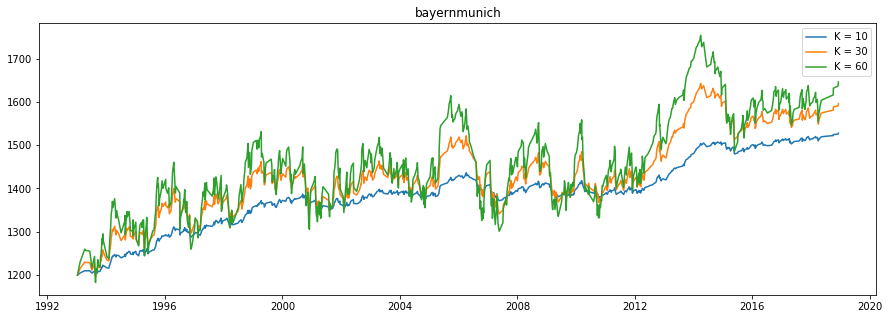

In [13]:
team = 'bayernmunich'
plt.figure(figsize=(15,5))

plt.plot(match_dates[team], np.array(elo_def_ratings[team][:-1]), label='K = 10')
plt.plot(match_dates[team], np.array(elo_30_ratings[team][:-1]), label='K = 30')

plt.plot(match_dates[team], np.array(elo_60_ratings[team][:-1]), label='K = 60')

plt.legend()
_ = plt.title(team)

In [14]:
# get win probability between eintracht and bayern
def expect(ratings, alg):
    R_E = ratings['einfrankfurt']
    R_B = ratings['bayernmunich']
    E = []
    for r1, r2 in zip(R_E, R_B):
        E.append(alg.expect(r1, r2))
    return E

Text(0.5, 1.0, 'Eintracht win probability vs Bayern, based on Elo')

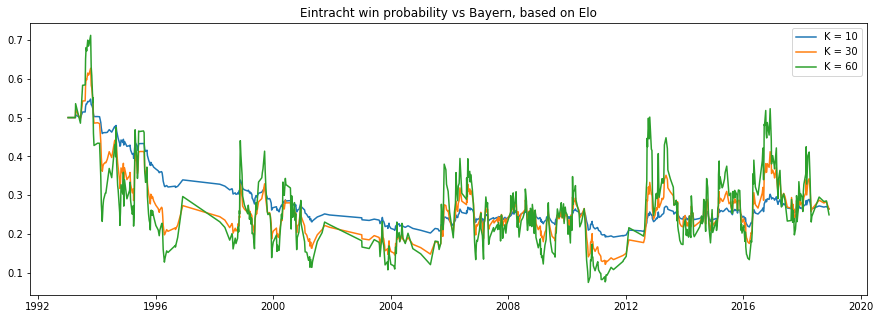

In [16]:
plt.figure(figsize=(15,5))
for ratings, alg, label in zip([elo_def_ratings, elo_30_ratings, elo_60_ratings], [Elo_def, Elo_30, Elo_60], [' 10', ' 30', ' 60']):
    plt.plot(match_dates['einfrankfurt'], expect(ratings, alg)[:-1], label='K ='+label)
plt.legend()
plt.title('Eintracht win probability vs Bayern, based on Elo')

In [65]:
teams_played = bl.loc[[i for i in participation['einfrankfurt'] if i in participation['bayernmunich']]]
bm_loss = teams_played.loser.value_counts()['bayernmunich']
draw = teams_played.draw.sum()
bm_win = len(teams_played) - bm_loss - draw
print('EF won {:.2f}% of the games and {:.2f}% ended in a draw.'.format(100*bm_loss/len(teams_played), 100*draw/len(teams_played)))

EF won 28.95% of the games and 21.05% ended in a draw.


## Glicko

In [66]:
Glicko = GLICKO(mu=1500, phi=350)

In [67]:
gl_ratings = defaultdict(list)
gs_ratings = defaultdict(list)

for team in teams:
    gl_ratings[team].append(Glicko.create_rating(mu=1500, phi=350))
    gs_ratings[team].append(Glicko.create_rating(mu=1500, phi=350))

In [68]:
# rating period = day, one team plays one match per day so can just go through dataset
for idx, row in bl.iterrows():    
    winner_is_home, draw = get_matchup(row)
    if winner_is_home:
        winner = row.HomeTeam
        loser = row.AwayTeam
    else:
        winner = row.AwayTeam
        loser = row.HomeTeam
    update_ratings(Glicko, gl_ratings, winner, loser, draw)

In [69]:
for season in seasons:
    seasonal = bl[bl.Season == season]
    new_ratings = {}
    for team in teams:
        # get series:
        relevant = seasonal[(seasonal.HomeTeam == team) | (seasonal.AwayTeam == team)]
        rating = gs_ratings[team][-1]
        series = []
        for idx, row in relevant.iterrows():
            winner_is_home, draw = get_matchup(row)
            if row.HomeTeam == team:
                if draw: 
                    series.append((0.5, gs_ratings[row.AwayTeam][-1]))
                elif winner_is_home:
                    series.append((1, gs_ratings[row.AwayTeam][-1]))
                else:
                    series.append((0, gs_ratings[row.AwayTeam][-1]))
        if len(series) > 0:
            new_rating = Glicko.rate(rating, series)
        else:
            new_rating = Glicko.rate_1vs1(rating, rating, drawn=True)[0]
        new_ratings[team] = new_rating
    for k, v in new_ratings.items():
        gs_ratings[k].append(v)

In [70]:
def apply_confidence_glicko(glicko_rating):
    skill = []
    for r in glicko_rating:
        skill.append(r.mu - 2*r.phi)
    return np.array(skill)

In [71]:
season_start_date = bl.groupby('Season').first().Date

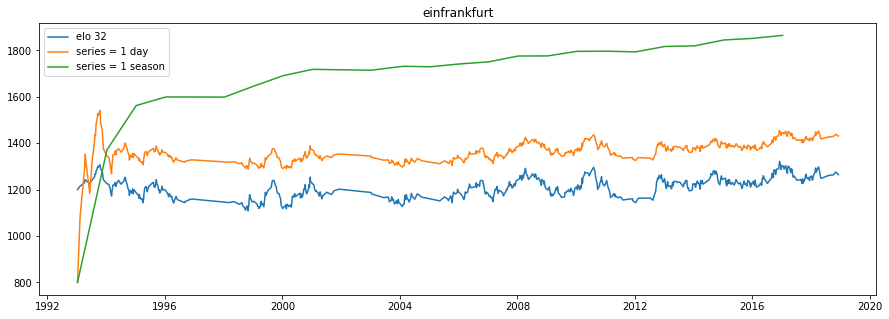

In [72]:
# plot season and day wide glicko
team = 'einfrankfurt'
plt.figure(figsize=(15,5))

plt.plot(match_dates[team], elo_30_ratings[team][:-1], label='elo 32')
plt.plot(match_dates[team], apply_confidence_glicko(np.array(gl_ratings[team][:-1])), label='series = 1 day')
plt.plot(season_start_date, apply_confidence_glicko(np.array(gs_ratings[team][:-1])), label='series = 1 season')

plt.legend()
_ = plt.title(team)

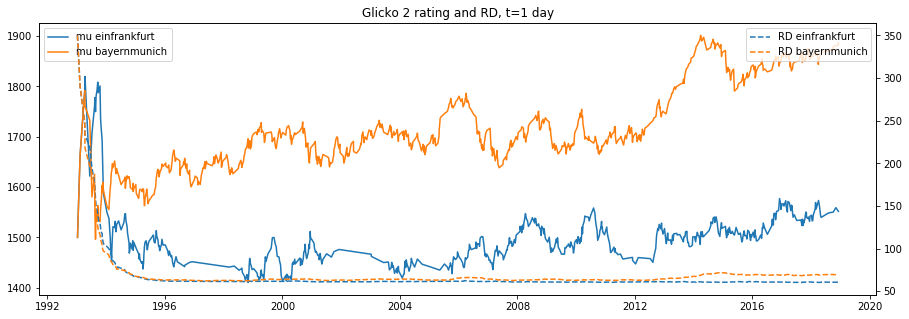

In [63]:
# plot mu and rd
team = 'einfrankfurt'
fix, ax1 = plt.subplots(figsize=(15,5))
ax2 = ax1.twinx()
ax1.plot(match_dates[team], np.array([i.mu for i in gl_ratings[team][:-1]]), label='mu ' + team)
ax2.plot(match_dates[team], np.array([i.phi for i in gl_ratings[team][:-1]]), '--', label='RD ' + team)
#ax2.plot(match_dates[team], np.array([i.sigma for i in gl_ratings[team][:-1]]), '--', label='sigma ' + team)


team = 'bayernmunich'
ax1.plot(match_dates[team], np.array([i.mu for i in gl_ratings[team][:-1]]), label='mu ' + team)
ax2.plot(match_dates[team], np.array([i.phi for i in gl_ratings[team][:-1]]), '--', label='RD ' + team)
#ax2.plot(match_dates[team], np.array([i.sigma for i in gl_ratings[team][:-1]]), '--', label='sigma ' + team)


#team = 'hamburg'
#ax1.plot(match_dates[team], np.array([i.mu for i in gl_ratings[team][:-1]]), label='mu ' + team)
#ax2.plot(match_dates[team], np.array([i.sigma for i in gl_ratings[team][:-1]]), '--', label='RD ' + team)

ax1.legend()
ax2.legend()
_ = plt.title('Glicko 2 rating and RD, t=1 day')

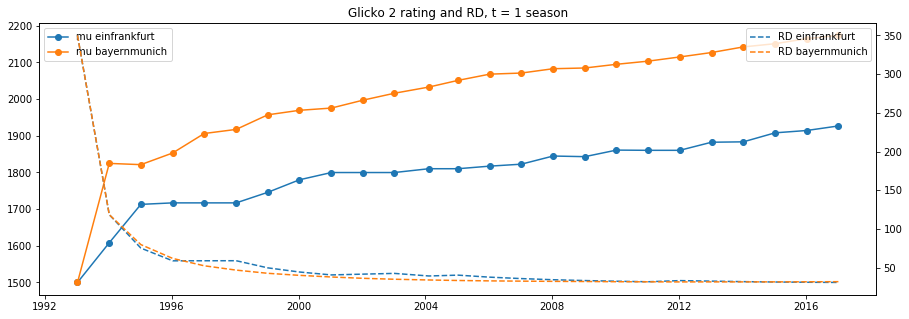

In [73]:
# plot mu and rd
team = 'einfrankfurt'
fix, ax1 = plt.subplots(figsize=(15,5))
ax2 = ax1.twinx()
ax1.plot(season_start_date, np.array([i.mu for i in gs_ratings[team][:-1]]), '-o', label='mu ' + team)
ax2.plot(season_start_date, np.array([i.phi for i in gs_ratings[team][:-1]]), '--', label='RD ' + team)
#ax2.plot(season_start_date, np.array([i.sigma for i in gs_ratings[team][1:]]), '--', label='volatility ' + team)

team = 'bayernmunich'
ax1.plot(season_start_date, np.array([i.mu for i in gs_ratings[team][:-1]]), '-o', label='mu ' + team)
ax2.plot(season_start_date, np.array([i.phi for i in gs_ratings[team][:-1]]), '--', label='RD ' + team)
#ax2.plot(season_start_date, np.array([i.sigma for i in gs_ratings[team][:-1]]), '--', label='volatility ' + team)

#team = 'hamburg'
#ax1.plot(season_start_date, np.array([i.mu for i in gs_ratings[team][:-1]]), '-o', label='mu ' + team)
#ax1.plot(season_start_date, np.array([i.phi for i in gs_ratings[team][:-1]]), '--', label='RD ' + team)
#ax2.plot(season_start_date, np.array([i.sigma for i in gs_ratings[team][:-1]]), '--', label='volatility ' + team)


ax1.legend()
ax2.legend()
_ = plt.title('Glicko 2 rating and RD, t = 1 season')

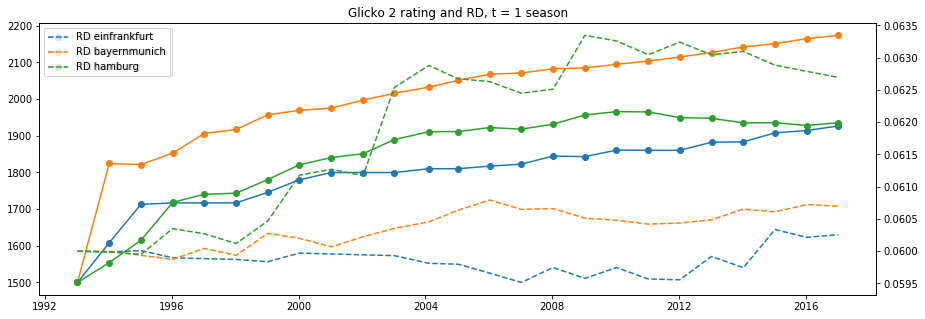

In [65]:
# plot mu and rd
team = 'einfrankfurt'
fix, ax1 = plt.subplots(figsize=(15,5))
ax2 = ax1.twinx()
ax1.plot(season_start_date, np.array([i.mu for i in gs_ratings[team][:-1]]), '-o', label='mu ' + team)
ax2.plot(season_start_date, np.array([i.sigma for i in gs_ratings[team][:-1]]), '--', label='RD ' + team)

team = 'bayernmunich'
ax1.plot(season_start_date, np.array([i.mu for i in gs_ratings[team][:-1]]), '-o', label='mu ' + team)
ax2.plot(season_start_date, np.array([i.sigma for i in gs_ratings[team][:-1]]), '--', label='RD ' + team)

team = 'hamburg'
ax1.plot(season_start_date, np.array([i.mu for i in gs_ratings[team][:-1]]), '-o', label='mu ' + team)
ax2.plot(season_start_date, np.array([i.sigma for i in gs_ratings[team][:-1]]), '--', label='RD ' + team)


ax1.legend()
ax2.legend()
_ = plt.title('Glicko 2 rating and RD, t = 1 season')

In [74]:
def normalize(ratings, team):
    max_rating = max([max(i) for i in ratings.values()])
    min_rating = min([min(i) for i in ratings.values()])
    ratings = np.array(ratings[team])
    return (ratings - min_rating) / (max_rating - min_rating)

def apply_confidence_ts(ts_rating):
    skill = []
    for r in ts_rating:
        skill.append(r.mu - 2*r.sigma)
    return np.array(skill)

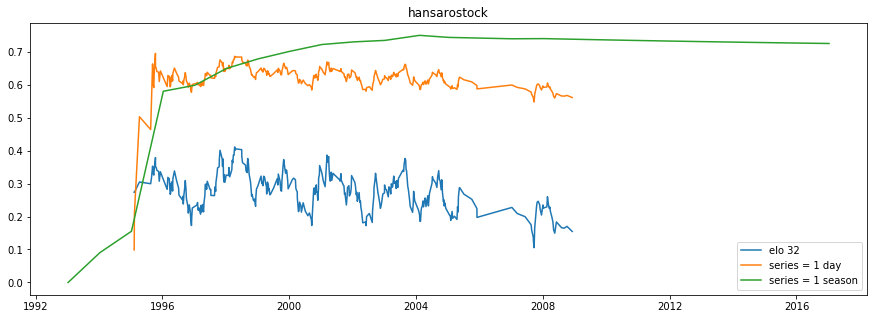

In [78]:
# plot season and day wide glicko
team = 'hansarostock'
plt.figure(figsize=(15,5))

plt.plot(match_dates[team], normalize(elo_30_ratings, team)[:-1], label='elo 32')

glicko_conf = dict(zip(teams, [apply_confidence_glicko(gl_ratings[i]) for i in teams]))
plt.plot(match_dates[team], normalize(glicko_conf, team)[:-1], label='series = 1 day')

glicko_conf = dict(zip(teams, [apply_confidence_glicko(gs_ratings[i]) for i in teams]))
plt.plot(season_start_date, normalize(glicko_conf, team)[:-1], label='series = 1 season')

plt.legend()
_ = plt.title(team)

In [77]:
teams

['uerdingen',
 'wattenscheid',
 'augsburg',
 'bayernmunich',
 'munich1860',
 'dusseldorf',
 'ulm',
 'fortunadusseldorf',
 'freiburg',
 'aachen',
 'dortmund',
 "m'gladbach",
 'wolfsburg',
 'schalke04',
 'hannover',
 'leipzig',
 'bielefeld',
 'nurnberg',
 'greutherfurth',
 'rbleipzig',
 'kaiserslautern',
 'braunschweig',
 'leverkusen',
 'paderborn',
 'unterhaching',
 'dresden',
 'stpauli',
 'mainz',
 'ingolstadt',
 'cottbus',
 'duisburg',
 'hamburg',
 'hertha',
 'karlsruhe',
 'stuttgart',
 'bochum',
 'werderbremen',
 'einfrankfurt',
 'darmstadt',
 'hansarostock',
 'hoffenheim',
 'fckoln']